# Epilepsy etiology: a study on the principles leading to seizure events

### Necessary imports

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Hodgkin-Huxley model for one neuron in normal conditions

### Model definition
We define a function for the whole model.

In [4]:
def HH_ode(t, Y, params):

    # define the parameters
    V, m, h, n = Y
    C_m, g_Na, g_K, g_L, E_Na, E_K, E_L = params

    # define time-varying external current
    I_ext = I_injection(t)

    # gating variable rate functions
    def alpha_m(V):
        return 0.1*(V+40) / (1 - np.exp(-(V+40)/10)) if abs(V+40) > 1e-6 else 1.0
    def beta_m(V):
        return 4.0*np.exp(-(V+65)/18)

    def alpha_h(V):
        return 0.07*np.exp(-(V+65)/20)
    def beta_h(V):
        return 1.0/(1 + np.exp(-(V+35)/10))

    def alpha_n(V):
        return 0.01*(V+55) / (1 - np.exp(-(V+55)/10)) if abs(V+55) > 1e-6 else 0.1
    def beta_n(V):
        return 0.125*np.exp(-(V+65)/80)

    # ionic currents
    I_Na = g_Na * m**3 * h * (V - E_Na)
    I_K  = g_K  * n**4 * (V - E_K)
    I_L  = g_L  * (V - E_L)

    # HH ODEs
    dVdt = (I_ext - I_Na - I_K - I_L) / C_m
    dmdt = alpha_m(V)*(1 - m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1 - h) - beta_h(V)*h
    dndt = alpha_n(V)*(1 - n) - beta_n(V)*n

    return [dVdt, dmdt, dhdt, dndt]

### Injected current
We inject a current for a time window of 80 ms.

In [5]:
def I_injection(t):

    if t < 20:
        return 0.0
    elif t < 100:
        return 7.0
    else:
        return 0.0

### Setting up the parameters

In [6]:
t_start = 0.0
t_end   = 120.0
t_eval  = np.linspace(t_start, t_end, 5000)

In [7]:
# initial conditions
Y0 = [-65.0, 0.05, 0.60, 0.32]

# constants (as in Hodgkin & Huxley 1952)
C_m  = 1.0     # µF/cm^2
g_Na = 120.0   # mS/cm^2
g_K  = 36.0    # mS/cm^2
g_L  = 0.3     # mS/cm^2
E_Na = 50.0    # mV
E_K  = -77.0   # mV
E_L  = -54.387 # mV

params = (C_m, g_Na, g_K, g_L, E_Na, E_K, E_L)

### Solving the equations with the solve_ivp function from SciPy
We opt for the Runge-Kutta method.

In [8]:
solution = solve_ivp(
    HH_ode,
    [t_start, t_end],
    Y0,
    args=(params,),
    t_eval=t_eval,
    method='RK45'
)

### Plot of the spiking activity

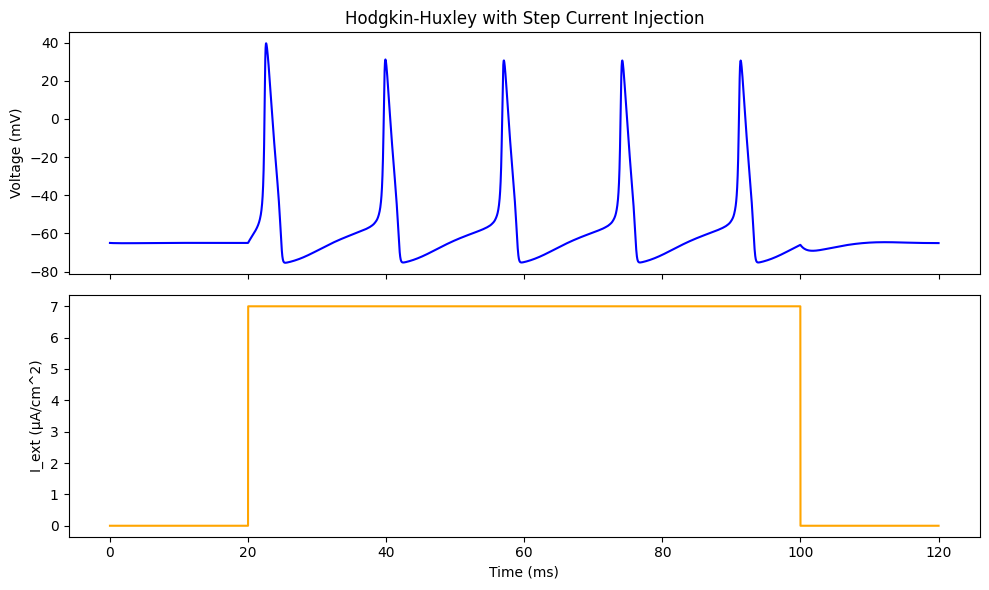

In [9]:
V_trace = solution.y[0]  # membrane potential

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(solution.t, V_trace, color='blue')
ax1.set_ylabel('Voltage (mV)')
ax1.set_title('Hodgkin-Huxley with Step Current Injection')
ax1.grid(False)

# plot the input current for reference
I_trace = [I_injection(t) for t in solution.t]
ax2.plot(solution.t, I_trace, color='orange')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('I_ext (µA/cm^2)')
ax2.grid(False)

plt.tight_layout()
plt.show()

## Hodgkin-Huxley model for one pathological neuron

### Adding a seizure factor
We now generate a sigmoid function to smoothly transition from normal state (0) to seizure state (1).

In [10]:
def seizure_factor(t, t_onset=50, k=0.5):

    return 1.0 / (1.0 + np.exp(-k*(t - t_onset)))

 ### Model definition for pathologic activity
 For the new model, we add effective (time-dependent) conductances, so that they'll change at a defined time during the simulation.

In [11]:
def HH_ode_seizure(t, Y, params_normal, params_seizure):

    V, m, h, n = Y

    # unpack normal and seizure parameters
    C_m, g_Na_norm, g_K_norm, g_L, E_Na, E_K, E_L, I_ext = params_normal
    _, g_Na_seiz, g_K_seiz, _, _, _, _, _ = params_seizure

    # compute seizure factor for the transitions around t_onset
    s = seizure_factor(t)

    # effective conductances
    g_Na_eff = g_Na_norm + s * (g_Na_seiz - g_Na_norm)
    g_K_eff  = g_K_norm  + s * (g_K_seiz  - g_K_norm)

    # gating variable rate functions
    def alpha_m(V):
        return 0.1*(V+40) / (1 - np.exp(-(V+40)/10)) if abs(V+40) > 1e-6 else 1.0
    def beta_m(V):
        return 4.0*np.exp(-(V+65)/18)

    def alpha_h(V):
        return 0.07*np.exp(-(V+65)/20)
    def beta_h(V):
        return 1.0 / (1 + np.exp(-(V+35)/10))

    def alpha_n(V):
        return 0.01*(V+55) / (1 - np.exp(-(V+55)/10)) if abs(V+55) > 1e-6 else 0.1
    def beta_n(V):
        return 0.125*np.exp(-(V+65)/80)

    # ionic currents using the effective conductances
    I_Na = g_Na_eff * (m**3) * h * (V - E_Na)
    I_K  = g_K_eff * (n**4) * (V - E_K)
    I_L  = g_L * (V - E_L)

    # ODEs
    dVdt = (I_ext - I_Na - I_K - I_L) / C_m
    dmdt = alpha_m(V)*(1 - m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1 - h) - beta_h(V)*h
    dndt = alpha_n(V)*(1 - n) - beta_n(V)*n

    return [dVdt, dmdt, dhdt, dndt]

### Setting up the parameters
Parameters are set up like before, but we modify Na+ and K+ in the vector for the seizure.

In [12]:
t_start = 0.0
t_end = 120.0
t_eval = np.linspace(t_start, t_end, 5000)

In [13]:
Y0 = [-65.0, 0.05, 0.60, 0.32]

params_normal = (1.0, 120.0, 36.0, 0.3, 50.0, -77.0, -54.387, 10.0)
params_seizure = (1.0, 180.0, 20.0, 0.3, 50.0, -77.0, -54.387, 10.0)

### Solving the equations

In [14]:
solution = solve_ivp(
    HH_ode_seizure,
    [t_start, t_end],
    Y0,
    args=(params_normal, params_seizure),
    t_eval=t_eval,
    method='RK45'
)

/var/folders/x6/3ljkq6l9301fxqkpg3n51z5h0000gn/T/ipykernel_14481/1086282248.py:18: RuntimeWarning: overflow encountered in exp
  return 0.1*(V+40) / (1 - np.exp(-(V+40)/10)) if abs(V+40) > 1e-6 else 1.0
/var/folders/x6/3ljkq6l9301fxqkpg3n51z5h0000gn/T/ipykernel_14481/1086282248.py:20: RuntimeWarning: overflow encountered in exp
  return 4.0*np.exp(-(V+65)/18)
/var/folders/x6/3ljkq6l9301fxqkpg3n51z5h0000gn/T/ipykernel_14481/1086282248.py:23: RuntimeWarning: overflow encountered in exp
  return 0.07*np.exp(-(V+65)/20)
/var/folders/x6/3ljkq6l9301fxqkpg3n51z5h0000gn/T/ipykernel_14481/1086282248.py:25: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-(V+35)/10))
/var/folders/x6/3ljkq6l9301fxqkpg3n51z5h0000gn/T/ipykernel_14481/1086282248.py:28: RuntimeWarning: overflow encountered in exp
  return 0.01*(V+55) / (1 - np.exp(-(V+55)/10)) if abs(V+55) > 1e-6 else 0.1
/var/folders/x6/3ljkq6l9301fxqkpg3n51z5h0000gn/T/ipykernel_14481/1086282248.py:30: RuntimeWarning: overflow

### Plot of the spiking activity
The red zone in the graph highlits the seizure activity.

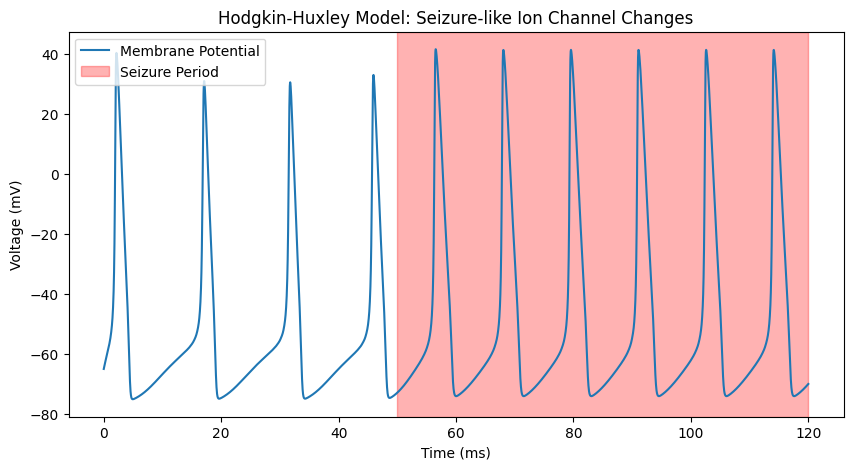

In [15]:
# plot the membrane potential over time
plt.figure(figsize=(10,5))
plt.plot(solution.t, solution.y[0], label='Membrane Potential')
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("Hodgkin-Huxley Model: Seizure-like Ion Channel Changes")
plt.axvspan(50, 120, color='red', alpha=0.3, label='Seizure Period')
plt.grid(False)
plt.legend()
plt.show()

### Plot of the changes in the conductances
We also plot the variation in the conductances over time to verify the transition.

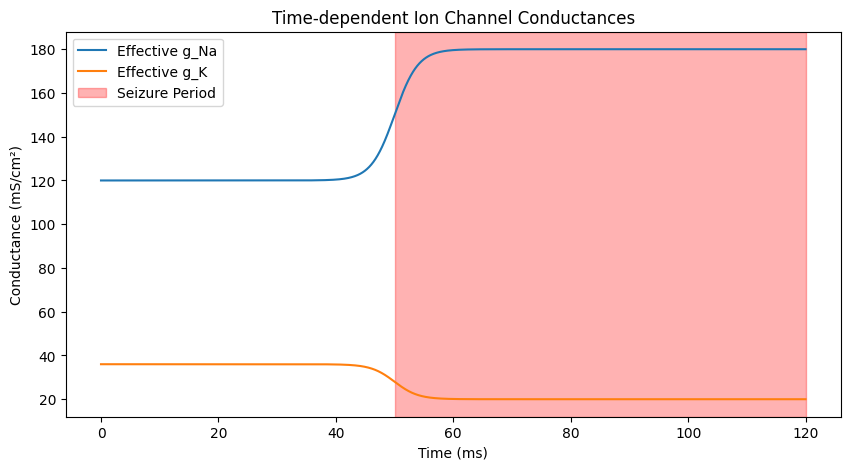

In [16]:
s_vals = seizure_factor(solution.t)  # vectorized evaluation
g_Na_eff = params_normal[1] + s_vals*(params_seizure[1] - params_normal[1])
g_K_eff  = params_normal[2] + s_vals*(params_seizure[2] - params_normal[2])

plt.figure(figsize=(10,5))
plt.plot(solution.t, g_Na_eff, label="Effective g_Na")
plt.plot(solution.t, g_K_eff, label="Effective g_K")
plt.xlabel("Time (ms)")

plt.axvspan(50, 120, color='red', alpha=0.3, label='Seizure Period')

plt.ylabel("Conductance (mS/cm²)")
plt.title("Time-dependent Ion Channel Conductances")
plt.legend()
plt.grid(False)
plt.show()

# The population case: moving to the mesoscale

## Wendling model for three populations

### Model definition
The differential equations and the sigmoidal tranfer function are both modeled after the original paper (Wendling et al., 2002). Since there are a lot of simulation parameters, we use a dictionary to handle them effectively.

In [17]:
def WendlingNMM(y, h, P ):

    noise =  np.random.normal(P["meanP"], P["sigmaP"])#

    dydx = np.zeros(10)

    dydx[0] = y[5]
    dydx[5] = P["A"] * P["a"] * sigm(y[1]-y[2]-y[3],P) - 2. * P["a"] * y[5] - P["a"] * P["a"] * y[0]
    dydx[1] = y[6]
    dydx[6] = P["A"] * P["a"] * (noise + P["C2"] * sigm(P["C1"]* y[0] + P["SG"],P)) - 2. * P["a"] * y[6] - P["a"]*P["a"] * y[1]
    dydx[2] = y[7];
    dydx[7] = P["B"] * P["b"] * (P["C4"] * sigm(P["C3"] * y[0],P)) - 2. * P["b"] * y[7] - P["b"]*P["b"] * y[2]
    dydx[3] = y[8];
    dydx[8] = P["G"] * P["g"] * (P["C7"] * sigm((P["C5"] * y[0] - P["C6"] * y[4]),P)) - 2. * P["g"] * y[8] - P["g"]*P["g"] * y[3]
    dydx[4] = y[9]
    dydx[9] = P["B"] * P["b"] * (sigm(P["C3"] * y[0],P)) - 2. * P["b"] * y[9] - P["b"]*P["b"] * y[4]

    yout = np.empty((0))

    for i in range(10):
        yout = np.append(yout,y[i]  + h *dydx[i])
    return yout

In [18]:
def sigm(v,P):

    return 2.*P["e0"]/(1.+np.exp(P["r"]*(P["v0"]-v)))

### Setting up the parameters

In [19]:
finalTime = 5 # simulation time
Fs = 512 # sampling frequency (Hz)
A = 4
B = 15
G = 22

All values refer to the ones used in the original simulation (Wendling et al., 2002).

In [20]:
P = {"A":A,"B":B,"G":G,"a":100.,"b":50.,"g":500.,"v0":6.,"e0":2.5,"r":0.56,
     "C1":1.,"C2":0.8,"C3":0.25,"C4":0.25,"C5":0.3,"C6":0.1,"C7":0.8,"C":135.}

P["C1"] *= P["C"]; P["C2"] *= P["C"]; P["C3"] *= P["C"]; P["C4"] *= P["C"]
P["C5"] *= P["C"]; P["C6"] *= P["C"]; P["C7"] *= P["C"];
P["SG"] = 1. # stimulus (synaptic) gain
P["meanP"] = 90. # input noise mean
P["sigmaP"] = 60. # input noise standard deviation
dt = 1./Fs # period
nb_fonc = 10 # Number of ODEs

nbSamples = int(finalTime / dt) # number of samples

### Simulating local field potential

In [21]:
simulatedLFP = np.zeros(nbSamples)
yold = np.zeros(nb_fonc)
xstates = np.zeros([nb_fonc,nbSamples])
tvec = np.zeros(nbSamples)
t = 0.

To solve the equations, this time we choose Euler's method, since it is less computationally expensive, but still retains efficiency.

In [22]:
for tt in range(nbSamples):
    ynew = WendlingNMM(yold,dt,P)
    yold = ynew
    tvec[tt] = t
    t += dt
    xstates[:,tt] = ynew
    simulatedLFP[tt] = ynew[1]-ynew[2]-ynew[3]

Text(0.5, 1.0, 'Simulated LFP')

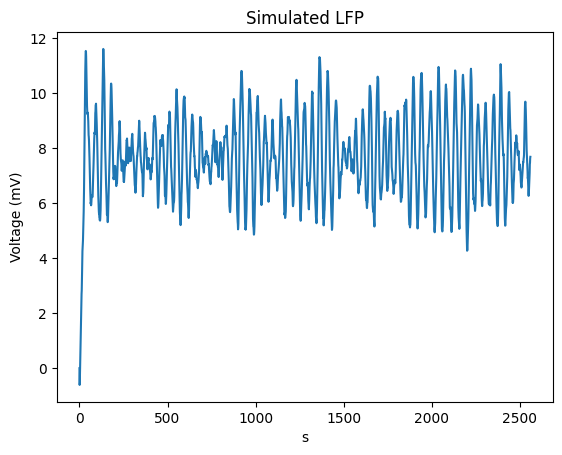

In [23]:
plt.figure()
plt.plot(simulatedLFP)
plt.xlabel('s')
plt.ylabel('Voltage (mV)')
plt.title('Simulated LFP')

## Modeling 6 different neuronal states

### Configuration list
The 6 configurations are defined following the activity maps in the original paper.

In [24]:
configs = [
    {"A": 3,    "B": 26,   "G": 10},
    {"A": 4,    "B": 26,   "G": 10},
    {"A": 5,    "B": 22,   "G": 10},
    {"A": 4,    "B": 15,   "G": 22},
    {"A": 6.5,  "B": 10,   "G": 22},
    {"A": 7,    "B": 18,   "G": 2}
]

### Plotting EEG signals for the 6 states

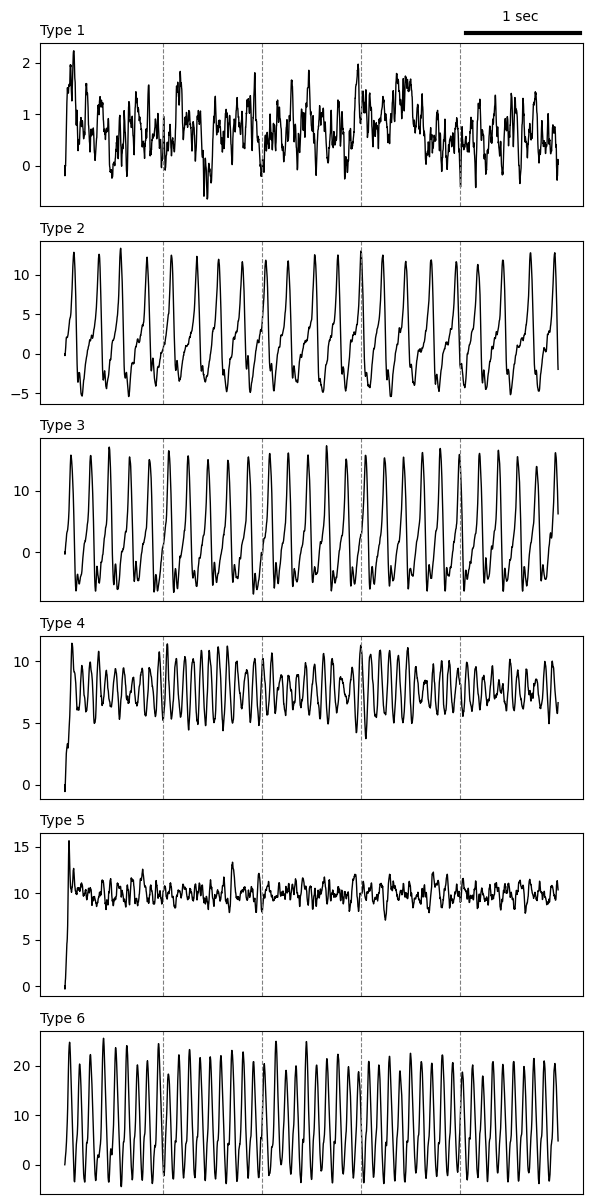

In [25]:
fig, axs = plt.subplots(6, 1, figsize=(6, 12), sharex=True)

reference_signals = []

# loop over each configuration and simulate
for i, config in enumerate(configs):

    # update model parameters for this configuration
    P["A"] = config["A"]
    P["B"] = config["B"]
    P["G"] = config["G"]

    # initialize simulation arrays and state variables
    simulatedLFP = np.zeros(nbSamples)
    yold = np.zeros(nb_fonc)
    xstates = np.zeros([nb_fonc, nbSamples])
    tvec = np.zeros(nbSamples)
    t = 0.0

    # run simulation using Euler integration
    for tt in range(nbSamples):
        ynew = WendlingNMM(yold, dt, P)
        yold = ynew
        tvec[tt] = t
        t += dt
        xstates[:, tt] = ynew
        simulatedLFP[tt] = ynew[1] - ynew[2] - ynew[3]

    reference_signals.append(simulatedLFP)

    # plot in the corresponding subplot
    axs[i].plot(tvec, simulatedLFP, 'k-', linewidth=1)  # black line

    # axis labels
    axs[i].set_xticks([])
    axs[i].spines['top'].set_visible(True)
    axs[i].spines['right'].set_visible(True)
    axs[i].spines['left'].set_visible(True)

    # title on the left side
    axs[i].set_title(f'Type {i+1}', loc='left', fontsize=10)

    # vertical dashed lines every second
    for j in range(1, 5):
        axs[i].axvline(j, linestyle='dashed', color='gray', linewidth=0.8)

# time scale bar outside the first subplot
fig.text(0.87, 0.99, "1 sec", fontsize=10, ha='center', color="black")  # text above the plot
fig.add_artist(plt.Line2D([0.78, 0.97], [0.98, 0.98], color='black', linewidth=3, transform=fig.transFigure, clip_on=False))  # line above the plot

# adjust layout
plt.tight_layout()
plt.show()

## Concatenation
Finally we aim to generate a realistic signal representing a full epileptic event.

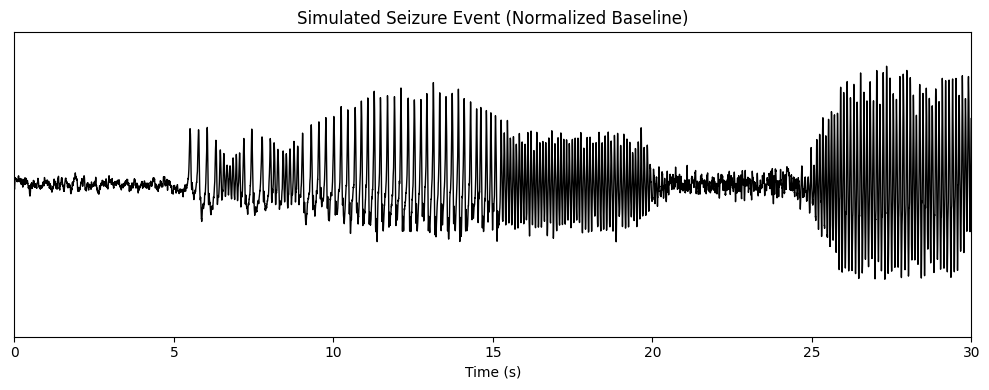

In [26]:
configs = [
    {"A": 3,    "B": 26, "G": 10},
    {"A": 3.5,  "B": 22, "G": 10},
    {"A": 4.5,  "B": 22, "G": 8},
    {"A": 5,    "B": 15, "G": 12},
    {"A": 6.5,  "B": 8,  "G": 22},
    {"A": 7,    "B": 18, "G": 3}
]

# function to get current parameters based on time t
def get_current_params(t, configs):
    # transition windows:
    # [4,6]: config0 -> config1
    # [9,11]: config1 -> config2
    # [14,16]: config2 -> config3
    # [19,21]: config3 -> config4
    # [24,26]: config4 -> config5

    if t < 4:
        return configs[0]
    elif t < 6:
        f = (t - 4) / 2.0
        return {
            "A": configs[0]["A"] * (1 - f) + configs[1]["A"] * f,
            "B": configs[0]["B"] * (1 - f) + configs[1]["B"] * f,
            "G": configs[0]["G"] * (1 - f) + configs[1]["G"] * f
        }
    elif t < 9:
        return configs[1]
    elif t < 11:
        f = (t - 9) / 2.0
        return {
            "A": configs[1]["A"] * (1 - f) + configs[2]["A"] * f,
            "B": configs[1]["B"] * (1 - f) + configs[2]["B"] * f,
            "G": configs[1]["G"] * (1 - f) + configs[2]["G"] * f
        }
    elif t < 14:
        return configs[2]
    elif t < 16:
        f = (t - 14) / 2.0
        return {
            "A": configs[2]["A"] * (1 - f) + configs[3]["A"] * f,
            "B": configs[2]["B"] * (1 - f) + configs[3]["B"] * f,
            "G": configs[2]["G"] * (1 - f) + configs[3]["G"] * f
        }
    elif t < 19:
        return configs[3]
    elif t < 21:
        f = (t - 19) / 2.0
        return {
            "A": configs[3]["A"] * (1 - f) + configs[4]["A"] * f,
            "B": configs[3]["B"] * (1 - f) + configs[4]["B"] * f,
            "G": configs[3]["G"] * (1 - f) + configs[4]["G"] * f
        }
    elif t < 24:
        return configs[4]
    elif t < 26:
        f = (t - 24) / 2.0
        return {
            "A": configs[4]["A"] * (1 - f) + configs[5]["A"] * f,
            "B": configs[4]["B"] * (1 - f) + configs[5]["B"] * f,
            "G": configs[4]["G"] * (1 - f) + configs[5]["G"] * f
        }
    else:
        return configs[5]

# simulation parameters
finalTime = 30       # simulation time in seconds
Fs = 512             # sampling frequency (Hz)
dt = 1.0 / Fs        # time step
nb_fonc = 10         # number of ODEs (state variables)
nbSamples = int(finalTime * Fs)

# define model parameters in dictionary P
P = {"A": 3, "B": 26, "G": 10, "a": 100., "b": 50., "g": 350.,
     "v0": 6., "e0": 2.5, "r": 0.56,
     "C1": 1., "C2": 0.8, "C3": 0.25, "C4": 0.25,
     "C5": 0.3, "C6": 0.1, "C7": 0.8, "C": 135.}

# scale connectivity constants:
P["C1"] *= P["C"]; P["C2"] *= P["C"]; P["C3"] *= P["C"]; P["C4"] *= P["C"]
P["C5"] *= P["C"]; P["C6"] *= P["C"]; P["C7"] *= P["C"]
P["SG"] = 1.        # stimulus (synaptic) gain
P["meanP"] = 90.    # noise mean
P["sigmaP"] = 60.   # noise standard deviation

# run simulation using Euler integration with time-varying parameters
simulatedLFP = np.zeros(nbSamples)
tvec = np.zeros(nbSamples)
yold = np.zeros(nb_fonc)  # initial state (all zeros)

t = 0.0
for tt in range(nbSamples):
    current_params = get_current_params(t, configs)
    P["A"] = current_params["A"]
    P["B"] = current_params["B"]
    P["G"] = current_params["G"]

    ynew = WendlingNMM(yold, dt, P)
    yold = ynew
    tvec[tt] = t
    t += dt
    simulatedLFP[tt] = ynew[1] - ynew[2] - ynew[3]

# normalize the signal at each point using a moving average baseline:
window_size = int(1.0 * Fs)  # 1-second window (adjust as needed)
# compute the moving average baseline via convolution:
baseline = np.convolve(simulatedLFP, np.ones(window_size)/window_size, mode='same')
normalizedLFP = simulatedLFP - baseline

# plot the full 30-second normalized LFP trace with fixed axes and centered vertically
plt.figure(figsize=(10, 4))
plt.plot(tvec, normalizedLFP, 'k-', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('')         # remove the voltage label
plt.title('Simulated Seizure Event (Normalized Baseline)')
plt.xlim(0, 30)
plt.ylim(-20, 20)      # center the baseline (0) vertically
plt.gca().set_yticks([])  # remove y-axis tick marks
plt.tight_layout()
plt.show()